## 6.6.6 Challenge

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['6.6.6 Challenge.ipynb', '.ipynb_checkpoints', 'fruits-360_dataset_2018_02_08']


Now take your Keras skills and go build another neural network. Pick your data set, but it should be one of abstract types, possibly even nonnumeric, and use Keras to make five implementations of your network. Compare them both in computational complexity as well as in accuracy and given that tradeoff decide which one you like best.

Your dataset should be sufficiently large for a neural network to perform well (samples should really be in the thousands here) and try to pick something that takes advantage of neural networks’ ability to have both feature extraction and supervised capabilities, so don’t pick something with an easy to consume list of features already generated for you (though neural networks can still be useful in those contexts).

Note that if you want to use an unprocessed image dataset, scikit-image is a useful package for converting to importable numerics.

### Objective

The goal of this project is to implement the Keras skills, and use them to build five different models on a given dataset, evaluate them and choose the one we like best.

### Dataset

I chose a dataset with a selection 75 different fruits, containing 50590 images. The goal is to split the data into training and test sets, train the corresponding set with each of our models, and evaluate it's performance on the testing set, on how well does it identify each fruit.

__Dataset properties:__

Total number of images: 50590.

Training set size: 37836 images (one fruit per image).

Test set size: 12709 images (one fruit per image).

Multi-fruits set size: 45 images (more than one fruit (or fruit class) per image)

Number of classes: 75 (fruits).

Image size: 100x100 pixels.

Filename format: image_index_100.jpg (e.g. 32_100.jpg) or r_image_index_100.jpg (e.g. r_32_100.jpg) or r2_image_index_100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).

Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

__Note:__

I used aproximately half of the dataset since my computer freezed each time I tried to train and test with all the original number of images.

__Sections:__

[Text Processing](#section1)<br>
[Unsupervised Feature Generation](#section2)<br>
[Supervised Learning Models](#section3)<br>
[Conclusion](#section4)

### Training set

The dataset is already divided into training and testing folders from it's source.

In [2]:
#Listing the training set
fruit_images = []
labels = [] 
for fruit_dir_path in glob.glob("../input/*/fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [3]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [4]:
id_to_label_dict

{0: 'Apple Braeburn',
 1: 'Apple Golden 1',
 2: 'Apple Golden 2',
 3: 'Apple Golden 3',
 4: 'Apple Granny Smith',
 5: 'Apple Red 1',
 6: 'Apple Red 2',
 7: 'Apple Red 3',
 8: 'Apple Red Delicious',
 9: 'Apple Red Yellow',
 10: 'Apricot',
 11: 'Avocado',
 12: 'Avocado ripe',
 13: 'Banana',
 14: 'Banana Red',
 15: 'Cactus fruit',
 16: 'Cantaloupe 1',
 17: 'Cantaloupe 2',
 18: 'Carambula',
 19: 'Cherry 1',
 20: 'Cherry 2',
 21: 'Cherry Rainier',
 22: 'Cherry Wax Black',
 23: 'Cherry Wax Red',
 24: 'Cherry Wax Yellow',
 25: 'Clementine',
 26: 'Cocos'}

In [5]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [6]:
fruit_images.shape, label_ids.shape, labels.shape

((13622, 45, 45, 3), (13622,), (13622,))

## Test set

In [7]:
#Listing the testing set
validation_fruit_images = []
validation_labels = [] 
for fruit_dir_path in glob.glob("../input/*/fruits-360/Test/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [8]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])

In [9]:
validation_fruit_images.shape, validation_label_ids.shape

((4564, 45, 45, 3), (4564,))

## Splitting the data

In [10]:
X_train, X_test = fruit_images, validation_fruit_images
Y_train, Y_test = label_ids, validation_label_ids

#Normalize color values to between 0 and 1
X_train = X_train/255
X_test = X_test/255

#Reshaping to a flattened version
X_flat_train = X_train.reshape(X_train.shape[0], 45*45*3)
X_flat_test = X_test.reshape(X_test.shape[0], 45*45*3)

#Encoding the output
Y_train = keras.utils.to_categorical(Y_train, 60)
Y_test = keras.utils.to_categorical(Y_test, 60)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_flat_train.shape, X_flat_test.shape)

Original Sizes: (13622, 45, 45, 3) (4564, 45, 45, 3) (13622, 60) (4564, 60)
Flattened: (13622, 6075) (4564, 6075)


(45, 45, 3)


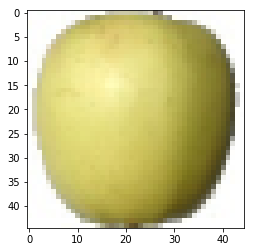

In [11]:
print(X_train[0].shape)
plt.imshow(X_train[0])
plt.show()

## Building our Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD

# Import the backend
from keras import backend as K

## Running models

#### 1. Multi Layer Perceptron
We will start with a simple sequential model using two dense layers of 128 nodes and 64 nodes respectively with a Rectified Linear Unit activation funcion. 

In [13]:
model_dense = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_dense.add(Dense(128, activation='relu', input_shape=(X_flat_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model_dense.add(Dropout(0.1))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model_dense.add(Dense(60, activation='softmax'))

model_dense.summary()

# Compile the model to put it all together.
model_dense.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_dense = model_dense.fit(X_flat_train, Y_train,
                          batch_size=128,
                          epochs=10,
                          verbose=1,
                          validation_data=(X_flat_test, Y_test))
score = model_dense.evaluate(X_flat_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               777728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3900      
Total params: 789,884
Trainable params: 789,884
Non-trainable params: 0
_________________________________________________________________
Train on 13622 samples, validate on 4564 samples
Epoch 1/10
13622/13622 [==============================] - 6s 429us/step - loss: 2.9407 

#### 2. Multi Layer Perceptron
We will now modify our latter model and add four dense layers, being a total of five, having the following nodes: 256, 128, 128, 128, 128, for each layer respectively, with a Rectified Linear Unit activation funcion.

In [14]:
model_deep = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_deep.add(Dense(256, activation='relu', input_shape=(X_flat_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
# End with a number of units equal to the number of classes we have for our outcome
model_deep.add(Dense(60, activation='softmax'))

model_deep.summary()

# Compile the model to put it all together.
model_deep.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_deep = model_deep.fit(X_flat_train, Y_train,
                          batch_size=128,
                          epochs=10,
                          verbose=1,
                          validation_data=(X_flat_test, Y_test))
score = model_deep.evaluate(X_flat_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               1555456   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
__________

#### 3. Convolutional Neural Network

Now will build and test Convolutional Neural Network, consisting of four layers with 32, 64, 128 and 60 nodes. We will run this model at one epoch.

In [15]:
model_cnn = Sequential()
# First convolutional layer, note the specification of shape
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(45, 45, 3)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(60, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 13622 samples, validate on 4564 samples
Epoch 1/1
13622/13622 [==============================] - 250s 18ms/step - loss: 1.9728 - acc: 0.4316 - val_loss: 0.7558 - val_acc: 0.7248
Test loss: 0.755786098638
Test accuracy: 0.72480280461


#### 4. Convolutional Neural Network

Now will use the same latter model, but we will train it for 10 epochs.

In [16]:
model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 13622 samples, validate on 4564 samples
Epoch 1/10
13622/13622 [==============================] - 242s 18ms/step - loss: 0.5352 - acc: 0.8137 - val_loss: 0.3218 - val_acc: 0.8946
Epoch 2/10
13622/13622 [==============================] - 243s 18ms/step - loss: 0.2384 - acc: 0.9137 - val_loss: 0.2341 - val_acc: 0.9016
Epoch 3/10
13622/13622 [==============================] - 244s 18ms/step - loss: 0.1376 - acc: 0.9496 - val_loss: 0.2062 - val_acc: 0.9360
Epoch 4/10
13622/13622 [==============================] - 243s 18ms/step - loss: 0.1144 - acc: 0.9567 - val_loss: 0.2048 - val_acc: 0.9373
Epoch 5/10
13622/13622 [==============================] - 244s 18ms/step - loss: 0.0774 - acc: 0.9690 - val_loss: 0.1545 - val_acc: 0.9340
Epoch 6/10
13622/13622 [==============================] - 243s 18ms/step - loss: 0.0756 - acc: 0.9685 - val_loss: 0.1348 - val_acc: 0.9437
Epoch 7/10
13622/13622 [==============================] - 243s 18ms/step - loss: 0.0798 - acc: 0.9658 - val_loss: 0.1

#### 5. Hierarchical Recurrrent Neural Networks

In [17]:
x_train = fruit_images
x_test = validation_fruit_images
y_train = label_ids
y_test = validation_label_ids

In [18]:
# Training parameters.
batch_size = 64
num_classes = 27
epochs = 3

# Embedding dimensions.
row_hidden = 32
col_hidden = 32

# Reshapes data to 4D for Hierarchical RNN.
x_train = x_train.reshape(x_train.shape[0], 45, 45, 3)
x_test = x_test.reshape(x_test.shape[0], 45, 45, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converts class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

row, col, pixel = x_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training.
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation.
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (13622, 45, 45, 3)
13622 train samples
4564 test samples
Train on 13622 samples, validate on 4564 samples
Epoch 1/3
13622/13622 [==============================] - 133s 10ms/step - loss: 3.0679 - acc: 0.0926 - val_loss: 2.6175 - val_acc: 0.2077
Epoch 2/3
13622/13622 [==============================] - 133s 10ms/step - loss: 2.3357 - acc: 0.2526 - val_loss: 2.2750 - val_acc: 0.2734
Epoch 3/3
13622/13622 [==============================] - 132s 10ms/step - loss: 1.8882 - acc: 0.3668 - val_loss: 1.6702 - val_acc: 0.4124
Test loss: 1.67024440811
Test accuracy: 0.412357581017


### Conlcusion

After running five different models, I can say that our first model MLP  was the most efficient given it's low running time and high accuracy. We can of course tune even more the different parameters, and try to optimize our model yielding a higher result. I was however surprised with the results of our last model using LSTM, however I believe we can raise this result modifying it's layers and adding more data to our dataset.
